In [1]:
import os
import shutil
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNet
from tensorflow.keras import layers, models

In [2]:
import zipfile
zip_path = '/content/augmented_dataset_.zip'

extract_folder = '/content/'

os.makedirs(extract_folder, exist_ok=True)

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_folder)

print(f"File ZIP telah diekstrak ke: {extract_folder}")


File ZIP telah diekstrak ke: /content/


In [3]:
def preprocess_image(image):
    image = tf.image.resize(image, (150, 150))
    image = image / 255.0
    return image

dataset_dir = './augmented_dataset/'
output_dir = './split_dataset/'

train_dir = os.path.join(output_dir, 'train')
val_dir = os.path.join(output_dir, 'validation')
os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)

for class_name in os.listdir(dataset_dir):
    class_path = os.path.join(dataset_dir, class_name)

    if os.path.isdir(class_path):
        os.makedirs(os.path.join(train_dir, class_name), exist_ok=True)
        os.makedirs(os.path.join(val_dir, class_name), exist_ok=True)

        images = [f for f in os.listdir(class_path) if f.endswith(('.jpg', '.png'))]

        train_images, val_images = train_test_split(images, test_size=0.2, random_state=42)

        for img in train_images:
            img_path = os.path.join(class_path, img)
            image = tf.io.read_file(img_path)
            image = tf.image.decode_jpeg(image, channels=3)
            image = preprocess_image(image)

            processed_img_path = os.path.join(train_dir, class_name, img)
            tf.keras.preprocessing.image.save_img(processed_img_path, image.numpy())

        for img in val_images:
            img_path = os.path.join(class_path, img)
            image = tf.io.read_file(img_path)
            image = tf.image.decode_jpeg(image, channels=3)
            image = preprocess_image(image)

            processed_img_path = os.path.join(val_dir, class_name, img)
            tf.keras.preprocessing.image.save_img(processed_img_path, image.numpy())


In [4]:
BATCH_SIZE = 32
IMG_SIZE = (224, 224)
class_names = os.listdir(train_dir)
num_classes = len(class_names)

training_dataset = tf.keras.utils.image_dataset_from_directory(
        directory='./split_dataset/train',
        batch_size=32,
        image_size=(150, 150),
        label_mode='int',
        shuffle=True,
        seed=7
    )

validation_dataset = tf.keras.utils.image_dataset_from_directory(
        directory='./split_dataset/validation',
        batch_size=32,
        image_size=(150, 150),
        label_mode='int',
        shuffle=True,
        seed=7
    )

class_names = validation_dataset.class_names

Found 10169 files belonging to 6 classes.
Found 2544 files belonging to 6 classes.


In [5]:
for batch in validation_dataset.take(1):
    images, labels = batch
    print(images.shape, labels.shape)

(32, 150, 150, 3) (32,)


In [6]:
val_batches = int(validation_dataset.cardinality())
split_index = val_batches // 5

test_dataset = validation_dataset.take(split_index)
validation_dataset = validation_dataset.skip(split_index)

print(f'Number of validation batches: {validation_dataset.cardinality()}')
print(f'Number of test batches: {test_dataset.cardinality()}')

Number of validation batches: 64
Number of test batches: 16


In [7]:
pre_trained_model = tf.keras.applications.MobileNet(
        include_top=False,
        input_shape=(150, 150, 3),
        weights='imagenet'
    )
pre_trained_model.trainable = False

<ipython-input-7-b3b5e872a232>:1: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  pre_trained_model = tf.keras.applications.MobileNet(


In [8]:
num_total_params = pre_trained_model.count_params()
num_trainable_params = sum([w.shape.num_elements() for w in pre_trained_model.trainable_weights])

print(f"There are {num_total_params:,} total parameters in this model.")
print(f"There are {num_trainable_params:,} trainable parameters in this model.")
pre_trained_model.summary()

There are 3,228,864 total parameters in this model.
There are 0 trainable parameters in this model.


Model: "mobilenet_1.00_224"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 150, 150, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1 (Conv2D)                       │ (None, 75, 75, 32)          │             864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1_bn (BatchNormalization)        │ (None, 75, 75, 32)          │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1_relu (ReLU)                    │ (None, 75, 75, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_1 (DepthwiseConv2D)          │ (None, 75, 75, 32)          │             288 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_1_bn (BatchNormalization)    │ (None, 75, 75, 32)          │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_1_relu (ReLU)                │ (None, 75, 75, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_1 (Conv2D)                   │ (None, 75, 75, 64)          │           2,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_1_bn (BatchNormalization)    │ (None, 75, 75, 64)          │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_1_relu (ReLU)                │ (None, 75, 75, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pad_2 (ZeroPadding2D)           │ (None, 76, 76, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_2 (DepthwiseConv2D)          │ (None, 37, 37, 64)          │             576 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_2_bn (BatchNormalization)    │ (None, 37, 37, 64)          │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_2_relu (ReLU)                │ (None, 37, 37, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_2 (Conv2D)                   │ (None, 37, 37, 128)         │           8,192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_2_bn (BatchNormalization)    │ (None, 37, 37, 128)         │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_2_relu (ReLU)                │ (None, 37, 37, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_3 (DepthwiseConv2D)          │ (None, 37, 37, 128)         │           1,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_3_bn (BatchNormalization)    │ (None, 37, 37, 128)         │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_3_relu (ReLU)                │ (None, 37, 37, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_3 (Conv2D)                   │ (None, 37, 37, 128)         │          16,384 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 3,228,864 (12.32 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 3,228,864 (12.32 MB)

In [9]:
class EarlyStoppingCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if logs['accuracy']>0.999:
            self.model.stop_training = True
            print("\nReached 99.9% accuracy so cancelling training!")

In [10]:
last_desired_layer = pre_trained_model.get_layer('conv_pw_13_relu')
last_output = last_desired_layer.output

print('last layer output shape: ', last_output.shape)

last layer output shape:  (None, 4, 4, 1024)


In [11]:
x = tf.keras.layers.Flatten()(last_output)
x = tf.keras.layers.Dense(1024, activation='relu')(x)
x = tf.keras.layers.Dropout(0.3)(x)
x = tf.keras.layers.Dense(num_classes, activation='softmax')(x)

model = tf.keras.Model(inputs=pre_trained_model.input, outputs=x)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)


In [12]:
training_dataset = training_dataset.map(lambda image, label: (tf.keras.applications.mobilenet.preprocess_input(image), label))
validation_dataset = validation_dataset.map(lambda image, label: (tf.keras.applications.mobilenet.preprocess_input(image), label))
test_dataset = test_dataset.map(lambda image, label: (tf.keras.applications.mobilenet.preprocess_input(image), label))


In [13]:
history = model.fit(
    training_dataset,
    validation_data = validation_dataset,
    epochs = 100,
    verbose = 2,
    callbacks = [EarlyStoppingCallback()],
)

Epoch 1/100
318/318 - 20s - 64ms/step - accuracy: 0.9583 - loss: 0.1887 - val_accuracy: 0.9921 - val_loss: 0.0311
Epoch 2/100
318/318 - 5s - 17ms/step - accuracy: 0.9921 - loss: 0.0272 - val_accuracy: 0.9961 - val_loss: 0.0219
Epoch 3/100
318/318 - 11s - 35ms/step - accuracy: 0.9913 - loss: 0.0478 - val_accuracy: 0.9946 - val_loss: 0.0140
Epoch 4/100
318/318 - 11s - 33ms/step - accuracy: 0.9954 - loss: 0.0235 - val_accuracy: 0.9941 - val_loss: 0.0425
Epoch 5/100
318/318 - 5s - 17ms/step - accuracy: 0.9953 - loss: 0.0266 - val_accuracy: 0.9852 - val_loss: 0.1401
Epoch 6/100
318/318 - 7s - 21ms/step - accuracy: 0.9948 - loss: 0.0367 - val_accuracy: 0.9931 - val_loss: 0.0300
Epoch 7/100
318/318 - 9s - 29ms/step - accuracy: 0.9976 - loss: 0.0100 - val_accuracy: 0.9951 - val_loss: 0.0670
Epoch 8/100
318/318 - 6s - 20ms/step - accuracy: 0.9979 - loss: 0.0111 - val_accuracy: 0.9956 - val_loss: 0.0442
Epoch 9/100
318/318 - 5s - 17ms/step - accuracy: 0.9954 - loss: 0.0338 - val_accuracy: 0.9941

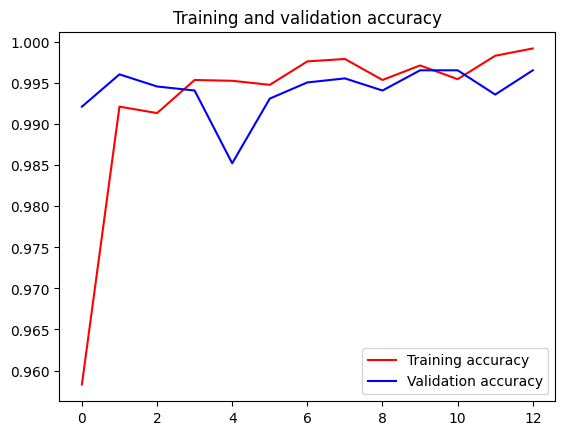

In [14]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.show()

In [15]:
test_loss, test_accuracy = model.evaluate(test_dataset)
print(f'Test loss: {test_loss},\nTest accuracy: {test_accuracy}')

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 1.0000 - loss: 0.0012
Test loss: 0.0003898578288499266,
Test accuracy: 1.0


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


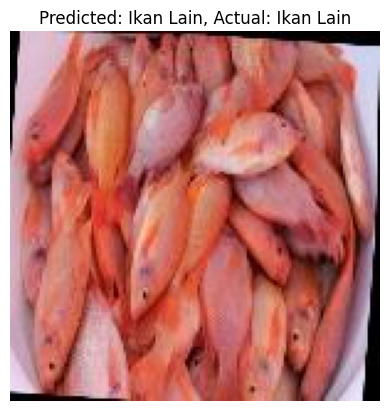

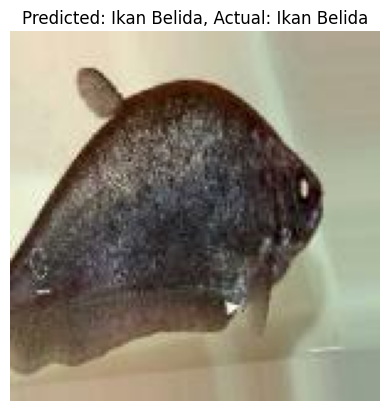

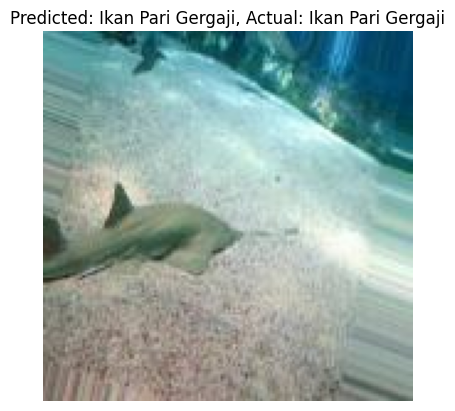

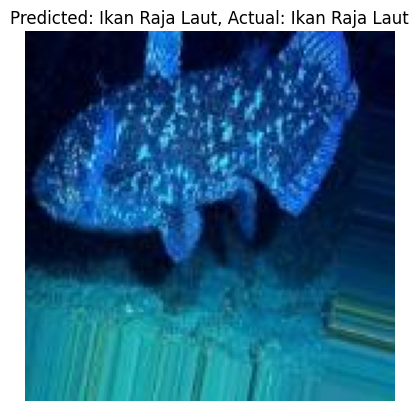

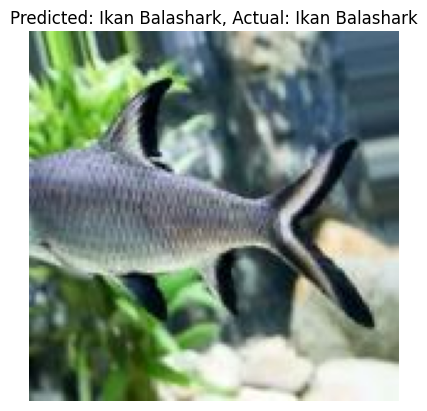

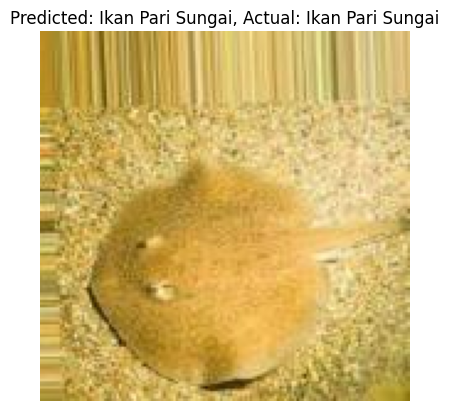

In [17]:
from tensorflow.keras.utils import load_img, img_to_array

dataset_dir = './split_dataset/validation/'
displayed_classes = set()

for images, labels in test_dataset:
    predictions = model.predict(images)
    predicted_classes = tf.argmax(predictions, axis=1)

    for i in range(len(images)):
        true_label = class_names[labels[i].numpy()]
        predicted_label = class_names[predicted_classes[i].numpy()]

        if true_label not in displayed_classes:
            displayed_classes.add(true_label)
            class_dir = os.path.join(dataset_dir, true_label)
            file_name = os.listdir(class_dir)[0]
            file_path = os.path.join(class_dir, file_name)

            img = load_img(file_path)
            img_array = img_to_array(img, dtype='uint8')

            plt.imshow(img_array.astype('uint8'))
            plt.title(f'Predicted: {predicted_label}, Actual: {true_label}')
            plt.axis('off')
            plt.show()

        if len(displayed_classes) == 6:
            break

    if len(displayed_classes) == 6:
        break

In [18]:
model.save('FishGuard.h5')

In [19]:
!zip -r split_dataset.zip split_dataset
from google.colab import files
files.download("split_dataset.zip")

Streaming output truncated to the last 5000 lines.
  adding: split_dataset/train/Ikan Pari Sungai/aug_0_4971.jpg (deflated 10%)
  adding: split_dataset/train/Ikan Pari Sungai/aug_0_6464.jpg (deflated 4%)
  adding: split_dataset/train/Ikan Pari Sungai/aug_0_2527.jpg (deflated 3%)
  adding: split_dataset/train/Ikan Pari Sungai/aug_0_1877.jpg (deflated 3%)
  adding: split_dataset/train/Ikan Pari Sungai/aug_0_1999.jpg (deflated 4%)
  adding: split_dataset/train/Ikan Pari Sungai/aug_0_9853.jpg (deflated 3%)
  adding: split_dataset/train/Ikan Pari Sungai/aug_0_2394.jpg (deflated 3%)
  adding: split_dataset/train/Ikan Pari Sungai/aug_0_5247.jpg (deflated 4%)
  adding: split_dataset/train/Ikan Pari Sungai/aug_0_4609.jpg (deflated 2%)
  adding: split_dataset/train/Ikan Pari Sungai/aug_0_7936.jpg (deflated 10%)
  adding: split_dataset/train/Ikan Pari Sungai/aug_0_8965.jpg (deflated 4%)
  adding: split_dataset/train/Ikan Pari Sungai/aug_0_8704.jpg (deflated 3%)
  adding: split_dataset/train/Ikan 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [20]:
import tensorflow as tf

model = tf.keras.models.load_model('FishGuard.h5')

converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

tflite_model_path = 'FishGuard.tflite'
with open(tflite_model_path, 'wb') as f:
    f.write(tflite_model)

print(f"Model telah berhasil dikonversi ke TFLite dan disimpan sebagai {tflite_model_path}.")


Saved artifact at '/tmp/tmp8av03zhm'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 150, 150, 3), dtype=tf.float32, name='input_layer')
Output Type:
  TensorSpec(shape=(None, 6), dtype=tf.float32, name=None)
Captures:
  134250500732208: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134250500825760: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134250500827696: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134250500821184: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134250500823472: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134250500830336: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134250500829632: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134250500832096: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134250500828576: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134250500829984: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134250500830864

In [21]:
interpreter = tf.lite.Interpreter(model_path='FishGuard.tflite')
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

correct_predictions = 0
total_predictions = 0

for images, labels in test_dataset:
    for i in range(len(images)):
        image = images[i:i+1]
        label = labels[i]

        interpreter.set_tensor(input_details[0]['index'], image.numpy())
        interpreter.invoke()

        prediction = interpreter.get_tensor(output_details[0]['index'])
        predicted_class = prediction.argmax(axis=1)[0]

        if predicted_class == label.numpy():
            correct_predictions += 1
        total_predictions += 1

tflite_accuracy = correct_predictions / total_predictions
print(f"TensorFlow Lite Model Accuracy: {tflite_accuracy:.4f}")


TensorFlow Lite Model Accuracy: 1.0000
